<a href="https://colab.research.google.com/github/RobSpiewakowski/Public_repository/blob/main/My_first_ML_project_with_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt końcowy:

W ramach projektu ML chcemy przewidzieć ceny ofert wycieczek zamieszczonych na portalu wakacje.pl na podstawie zadanych kryteriów:

* Kraj - Turcja
* Sposób dotarcia na miejsce - samolotem
* Czas trwania - 7 dni
* Rodzaj wyżywienia - All-inclusive

Średni błąd predykcji nie powinien przekraczać 500 zł / os.

Jak będziemy mierzyć spełnienie celu - metryki sukcesu:

MSE - błąd średniokwadratowy:
MSE = 1/N * SUMA(yi - średnia yi)^2

pierwiastek błędu średnniokwadratowego
Miara pozwala określić, w jakim stopniu model myli się w przewidywaniach.

In [52]:
# Import bibliotek:
import requests
import time
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.tree import DecisionTreeRegressor
from sklearn import pipeline
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from urllib.parse import urljoin
from sklearn.model_selection import train_test_split

Jakie informacje są dostępne w wyszukiwarce:

* Region i miejscowość,
* Liczba gwiazdek,
* Termin wyjazdu i powrotu,
* Miejsce wylotu,
* Rodzaj wyżywienia,
* Nazwa biura podróży,
* Ocena,
* Link do oferty.

# 1. Pobieranie danych ze źródła - scraping:

Wakacje.pl ogranicza wyniki wyszukiwania do 100 stron, więc jest to maksymalna liczba stron do zwscrapowania.

In [84]:
# Utworzenie żądania get():

# Prefiks linku, numer strony będzie zmieniał się w peli:
URL0 = 'https://www.wakacje.pl/wczasy/turcja/?str-'

oferty0 = []

#for i in range(1, 3):   # Do testów
for i in range(1, 101):
  time.sleep(1)

  URL = URL0 + str(i) + ',7-dni,samolotem,all-inclusive'                # Utworzenie linku
  zwrotna_odpowiedź = requests.get(URL)                   # Request
  print('Strona ', i, '| Status: ', zwrotna_odpowiedź)    # Wtświetl status odpowiedzi
  html = zwrotna_odpowiedź.content                        # Zawartość strony
  zupa = BeautifulSoup(html, 'lxml')                      # Gotowanie zupy (parsowanie)

  # Oferty ze sescrapowanej strony:
  x0 = str(zupa.find_all('script')[4]).split('{"data":')[1].split(',"searchObj"')[0].split('},{')
  oferty0.append(x0)
  
  # Pętla, która wyciągnie wszystkie elementy z podlist listy oferty_surowe i umieści je w nowej liście:
oferty = []
for i in range(len(oferty0)):
  lista_pomocnicza = oferty0[i]
  for j in range(len(lista_pomocnicza)):
    a = lista_pomocnicza[j].split('"offerHash"')[0]
    oferty.append(a)

print(len(oferty))

Strona  1 | Status:  <Response [200]>
Strona  2 | Status:  <Response [200]>
Strona  3 | Status:  <Response [200]>
Strona  4 | Status:  <Response [200]>
Strona  5 | Status:  <Response [200]>
Strona  6 | Status:  <Response [200]>
Strona  7 | Status:  <Response [200]>
Strona  8 | Status:  <Response [200]>
Strona  9 | Status:  <Response [200]>
Strona  10 | Status:  <Response [200]>
Strona  11 | Status:  <Response [200]>
Strona  12 | Status:  <Response [200]>
Strona  13 | Status:  <Response [200]>
Strona  14 | Status:  <Response [200]>
Strona  15 | Status:  <Response [200]>
Strona  16 | Status:  <Response [200]>
Strona  17 | Status:  <Response [200]>
Strona  18 | Status:  <Response [200]>
Strona  19 | Status:  <Response [200]>
Strona  20 | Status:  <Response [200]>
Strona  21 | Status:  <Response [200]>
Strona  22 | Status:  <Response [200]>
Strona  23 | Status:  <Response [200]>
Strona  24 | Status:  <Response [200]>
Strona  25 | Status:  <Response [200]>
Strona  26 | Status:  <Response [2

1. Pobieranie danych z ofert:

In [91]:
# Nazwa oferty:
nazwa_oferty = [oferty[i].split('"name":')[1].split('"placeName"')[0].lstrip('"').rstrip('",') for i in range(len(oferty))]

# Miejsce oferty:
miejsce_oferty = [oferty[i].split('"placeName":')[1].split('"link":')[0].lstrip('"').rstrip('",') for i in range(len(oferty))]

# Z miejsca wydłubiemy kraj i region:
kraj_oferty = [miejsce_oferty[j].split(' /')[0] for j in range(len(miejsce_oferty))]
region_oferty = []
for j in range(len(miejsce_oferty)):
  if '/' in miejsce_oferty[j]:
    a = miejsce_oferty[j].split(' /')[1]
  else:
    a = 'BRAK'
  region_oferty.append(a)

# Link do oferty:
# Prefiks linku do strony z oertami wczasów:
URL1 = 'https://www.wakacje.pl/oferty'

k = [oferty[i].split('"link":')[1].split(',"photo"')[0].strip('"') for i in range(len(oferty))]
link_oferty = [urljoin(URL1, k) for k in k]

# Kategoria hotelu:
kategoria_hotelu = [float(oferty[i].split('"category":')[1].split(',"maxCategory"')[0]) for i in range(len(oferty))]

# Czas trwania wczasów:
czas_trwania  =[oferty[i].split('"duration":')[1].split(',"durationNights"')[0] + ' dni' for i in range(len(oferty))]

# Termin wyjazdu:
termin_wyjazdu = [dt.datetime.strptime(oferty[i].split('"departureDate":')[1].split('"returnDate')[0].lstrip('"').rstrip('",'), "%Y-%m-%d").strftime("%d.%m.%Y") for i in range(len(oferty))]

# Rodzaj dojazdu:
dojazd_oferta = [oferty[i].split('"departureTypeName":')[1].split('"departurePlaces"')[0].lstrip('"').rstrip('",') for i in range(len(oferty))]

# Miejsce zbiórki:
zbiórka_oferta = [oferty[i].split('"departurePlace":')[1].split(',"returnDestinationPlace"')[0].lstrip('"').rstrip('"') for i in range(len(oferty))]

# Cena oferty:
cena_oferta = [float(oferty[i].split('"price":')[1].split(',"priceDiscount"')[0]) for i in range(len(oferty))]

# Nazwa biura podróży:
biuro_podróży = [oferty[i].split('"tourOperatorName":"')[1].split(',"ratingString')[0].rstrip('"') for i in range(len(oferty))]

# Ocena:
ocena_oferta = [float(oferty[i].split('"ratingValue":')[1].split(',"ratingLabel')[0]) for i in range(len(oferty))]

# Ocena opisowa:
ocena_oferta_opis = [oferty[i].split('"ratingLabel":"')[1].split('","ratingMax')[0] for i in range(len(oferty))]

# Typ pokoju:
pokój_oferta = [oferty[i].split('"roomType":"')[1].split('","offerType')[0] for i in range(len(oferty))]


# Ustawienie parametrów wyświetlania:
pd.set_option('display.width', 150)

# Tworzenie obiektu DataFrame:
df = pd.DataFrame({'Nazwa oferty' : nazwa_oferty,
                   'Kraj' : kraj_oferty,
                   'Region' : region_oferty,
                   'Kategoria hotelu' : kategoria_hotelu,
                   'Termin wyjazdu' : termin_wyjazdu,
                   'Czas trwania wczasów' : czas_trwania,
                   'Sposób dojazdu' : dojazd_oferta,
                   'Miejsce zbiórki' : zbiórka_oferta,
                   'Cena oferty' : cena_oferta,
                   'Nazwa biura podróży' : biuro_podróży,
                   'Ocena oferty ogólna' : ocena_oferta,
                   'Ocena oferty opis' : ocena_oferta_opis,
                   'Link do oferty' : link_oferty})

# Zamiana wartości brakujących:
df['Miejsce zbiórki'] = df['Miejsce zbiórki'].replace('null', 'Dojazd własny')

# Dodajmy jeszcze licznik dni do wyjazdu:
dziś = dt.datetime.today()
dziś_rok = dziś.year
dziś_miesiąc = dziś.month
dziś_dzień = dziś.day

dni_do_wyjazdu = []

for i in range(len(df['Termin wyjazdu'])):
  dzień = int(df['Termin wyjazdu'][i].split('.')[0])
  miesiąc = int(df['Termin wyjazdu'][i].split('.')[1])
  rok = int(df['Termin wyjazdu'][i].split('.')[2])
  
  dni = dt.date(rok, miesiąc, dzień) - dt.date(dziś_rok, dziś_miesiąc, dziś_dzień)
  dni_do_wyjazdu.append(dni.days)

df['Liczba dni do wyjazdu'] = dni_do_wyjazdu
df.head(10)

,Nazwa oferty,Kraj,Region,Kategoria hotelu,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Ocena oferty opis,Link do oferty,Liczba dni do wyjazdu
0,Ozkaymak Select,Turcja,Alanya,5.0,03.11.2021,7 dni,samolot,Katowice,1719.0,Coral Travel,8.4,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,70
1,Alexia Resort \u0026 Spa,Turcja,Side,5.0,24.10.2021,7 dni,samolot,Wrocław,2110.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,60
2,Club Blue Dreams,Turcja,Bodrum,5.0,10.10.2021,7 dni,samolot,Wrocław,2183.0,Coral Travel,9.0,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,46
3,Galeri Resort,Turcja,Alanya,5.0,06.11.2021,7 dni,samolot,Katowice,1832.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,73
4,The Marilis Hill Resort and Spa,Turcja,Alanya,5.0,06.10.2021,7 dni,samolot,Katowice,1782.0,Best Reisen,8.4,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,42
5,Blue Wave,Turcja,Alanya,4.0,20.10.2021,7 dni,samolot,Katowice,1678.0,Coral Travel,8.0,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,56
6,Kentia,Turcja,Side,4.0,23.10.2021,7 dni,samolot,Katowice,1678.0,Coral Travel,7.8,Dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,59
7,Raga,Turcja,Side,5.0,09.10.2021,7 dni,samolot,Rzeszów,2618.0,Coral Travel,9.8,Fantastyczny,https://www.wakacje.pl/oferty/turcja/riwiera-t...,45
8,Club Side Coast,Turcja,Side,5.0,03.11.2021,7 dni,samolot,Katowice,1605.0,Coral Travel,8.1,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,70
9,Oz Side Premium,Turcja,Side,5.0,06.11.2021,7 dni,samolot,Katowice,1946.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,73


In [92]:
# Zapisanie pliku z danymi:
df.to_csv('dane_wakacjepl.csv', index = False)

# 2. Wstępna analiza i przygotowanie danych:

In [93]:
dane = pd.read_csv('/content/dane_wakacjepl.csv')
dane.head(10)

,Nazwa oferty,Kraj,Region,Kategoria hotelu,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Ocena oferty opis,Link do oferty,Liczba dni do wyjazdu
0,Ozkaymak Select,Turcja,Alanya,5.0,03.11.2021,7 dni,samolot,Katowice,1719.0,Coral Travel,8.4,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,70
1,Alexia Resort \u0026 Spa,Turcja,Side,5.0,24.10.2021,7 dni,samolot,Wrocław,2110.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,60
2,Club Blue Dreams,Turcja,Bodrum,5.0,10.10.2021,7 dni,samolot,Wrocław,2183.0,Coral Travel,9.0,Wspaniały,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,46
3,Galeri Resort,Turcja,Alanya,5.0,06.11.2021,7 dni,samolot,Katowice,1832.0,Coral Travel,8.9,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,73
4,The Marilis Hill Resort and Spa,Turcja,Alanya,5.0,06.10.2021,7 dni,samolot,Katowice,1782.0,Best Reisen,8.4,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,42
5,Blue Wave,Turcja,Alanya,4.0,20.10.2021,7 dni,samolot,Katowice,1678.0,Coral Travel,8.0,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,56
6,Kentia,Turcja,Side,4.0,23.10.2021,7 dni,samolot,Katowice,1678.0,Coral Travel,7.8,Dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,59
7,Raga,Turcja,Side,5.0,09.10.2021,7 dni,samolot,Rzeszów,2618.0,Coral Travel,9.8,Fantastyczny,https://www.wakacje.pl/oferty/turcja/riwiera-t...,45
8,Club Side Coast,Turcja,Side,5.0,03.11.2021,7 dni,samolot,Katowice,1605.0,Coral Travel,8.1,Bardzo dobry,https://www.wakacje.pl/oferty/turcja/riwiera-t...,70
9,Oz Side Premium,Turcja,Side,5.0,06.11.2021,7 dni,samolot,Katowice,1946.0,Coral Travel,8.8,Wspaniały,https://www.wakacje.pl/oferty/turcja/riwiera-t...,73


1. Czyszczenie danych:

Czyszczenie danych w zaleśności od regionu. Wiemy, że te miejscowości są zlokalizowane w konkretnych regionach, np. Alanya, Side, Kemer, Belek i Antalya znajdują się na riwierze Tureckiej a Kusadasi, Marmaris, Bodrum i Dalaman - na riwierze Egejskiej. Pogrupujmy je i wywalmy wycieczki objazdowe, bo nie są nam do niczego potrzebne:

In [94]:
# Liczba ofert w zaleśności od regionu:
dane['Region'].value_counts(dropna = False)

 Alanya               328
 Side                 233
 Bodrum               138
 Kemer                 95
 Belek                 68
 Kusadasi              41
 Antalya               40
 Marmaris              37
 Dalaman - Fethiye     19
 Cesme                  1
Name: Region, dtype: int64

In [96]:
dane['Region'] = dane['Region'].replace(' Alanya', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Side', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Kemer', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Belek', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Antalya', 'Riwiera Turecka')
dane['Region'] = dane['Region'].replace(' Bodrum', 'Riwiera Egejska')
dane['Region'] = dane['Region'].replace(' Kusadasi', 'Riwiera Egejska')
dane['Region'] = dane['Region'].replace(' Marmaris', 'Riwiera Egejska')
dane['Region'] = dane['Region'].replace(' Dalaman - Fethiye', 'Riwiera Egejska')
dane['Region'] = dane['Region'].replace(' Cesme', 'Riwiera Egejska')
dane['Region'] = dane['Region'].replace(' Turcja', 'Riwiera Turecka')
dane = dane[dane['Region'] != ' Wyc. Objazdowe']
dane['Region'].value_counts(dropna = False)

Riwiera Turecka    764
Riwiera Egejska    236
Name: Region, dtype: int64

In [97]:
# Gdzie są braki danych:
dane.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Nazwa oferty           1000 non-null   object 
 1   Kraj                   1000 non-null   object 
 2   Region                 1000 non-null   object 
 3   Kategoria hotelu       1000 non-null   float64
 4   Termin wyjazdu         1000 non-null   object 
 5   Czas trwania wczasów   1000 non-null   object 
 6   Sposób dojazdu         1000 non-null   object 
 7   Miejsce zbiórki        1000 non-null   object 
 8   Cena oferty            1000 non-null   float64
 9   Nazwa biura podróży    1000 non-null   object 
 10  Ocena oferty ogólna    1000 non-null   float64
 11  Ocena oferty opis      882 non-null    object 
 12  Link do oferty         1000 non-null   object 
 13  Liczba dni do wyjazdu  1000 non-null   int64  
dtypes: float64(3), int64(1), object(10)
memory usage: 117.2+ 

In [98]:
# Jak widzisz w opisowej ocenie oferty występują braki. Usuńmy zatem tę kolumnę:
dane = dane.drop(columns = 'Ocena oferty opis')
dane.head(10)

,Nazwa oferty,Kraj,Region,Kategoria hotelu,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Link do oferty,Liczba dni do wyjazdu
0,Ozkaymak Select,Turcja,Riwiera Turecka,5.0,03.11.2021,7 dni,samolot,Katowice,1719.0,Coral Travel,8.4,https://www.wakacje.pl/oferty/turcja/riwiera-t...,70
1,Alexia Resort \u0026 Spa,Turcja,Riwiera Turecka,5.0,24.10.2021,7 dni,samolot,Wrocław,2110.0,Coral Travel,8.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,60
2,Club Blue Dreams,Turcja,Riwiera Egejska,5.0,10.10.2021,7 dni,samolot,Wrocław,2183.0,Coral Travel,9.0,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,46
3,Galeri Resort,Turcja,Riwiera Turecka,5.0,06.11.2021,7 dni,samolot,Katowice,1832.0,Coral Travel,8.9,https://www.wakacje.pl/oferty/turcja/riwiera-t...,73
4,The Marilis Hill Resort and Spa,Turcja,Riwiera Turecka,5.0,06.10.2021,7 dni,samolot,Katowice,1782.0,Best Reisen,8.4,https://www.wakacje.pl/oferty/turcja/riwiera-t...,42
5,Blue Wave,Turcja,Riwiera Turecka,4.0,20.10.2021,7 dni,samolot,Katowice,1678.0,Coral Travel,8.0,https://www.wakacje.pl/oferty/turcja/riwiera-t...,56
6,Kentia,Turcja,Riwiera Turecka,4.0,23.10.2021,7 dni,samolot,Katowice,1678.0,Coral Travel,7.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,59
7,Raga,Turcja,Riwiera Turecka,5.0,09.10.2021,7 dni,samolot,Rzeszów,2618.0,Coral Travel,9.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,45
8,Club Side Coast,Turcja,Riwiera Turecka,5.0,03.11.2021,7 dni,samolot,Katowice,1605.0,Coral Travel,8.1,https://www.wakacje.pl/oferty/turcja/riwiera-t...,70
9,Oz Side Premium,Turcja,Riwiera Turecka,5.0,06.11.2021,7 dni,samolot,Katowice,1946.0,Coral Travel,8.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,73


Czyszczenie danych ze względu na kategorię hotelu (czyli gwiazdki). Mamy tu aż 4 oferty z zerem gwiazdek. Może to błąd a może tak żałosne oferty, że nie zasługują na pozostanie wśród danych. Wylatują:

In [99]:
# Liczba ofert wegług kategorii hotelu:
dane["Kategoria hotelu"].value_counts(dropna = False)

5.0    640
4.0    274
3.0     64
4.5     12
3.5      9
0.0      1
Name: Kategoria hotelu, dtype: int64

In [100]:
# Co to za hotele z zeroma gwiazdkami? Usuwamy je:
dane = dane[dane['Kategoria hotelu'] != 0]
print(dane.shape)
dane.head(10)

(999, 13)


,Nazwa oferty,Kraj,Region,Kategoria hotelu,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Ocena oferty ogólna,Link do oferty,Liczba dni do wyjazdu
0,Ozkaymak Select,Turcja,Riwiera Turecka,5.0,03.11.2021,7 dni,samolot,Katowice,1719.0,Coral Travel,8.4,https://www.wakacje.pl/oferty/turcja/riwiera-t...,70
1,Alexia Resort \u0026 Spa,Turcja,Riwiera Turecka,5.0,24.10.2021,7 dni,samolot,Wrocław,2110.0,Coral Travel,8.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,60
2,Club Blue Dreams,Turcja,Riwiera Egejska,5.0,10.10.2021,7 dni,samolot,Wrocław,2183.0,Coral Travel,9.0,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,46
3,Galeri Resort,Turcja,Riwiera Turecka,5.0,06.11.2021,7 dni,samolot,Katowice,1832.0,Coral Travel,8.9,https://www.wakacje.pl/oferty/turcja/riwiera-t...,73
4,The Marilis Hill Resort and Spa,Turcja,Riwiera Turecka,5.0,06.10.2021,7 dni,samolot,Katowice,1782.0,Best Reisen,8.4,https://www.wakacje.pl/oferty/turcja/riwiera-t...,42
5,Blue Wave,Turcja,Riwiera Turecka,4.0,20.10.2021,7 dni,samolot,Katowice,1678.0,Coral Travel,8.0,https://www.wakacje.pl/oferty/turcja/riwiera-t...,56
6,Kentia,Turcja,Riwiera Turecka,4.0,23.10.2021,7 dni,samolot,Katowice,1678.0,Coral Travel,7.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,59
7,Raga,Turcja,Riwiera Turecka,5.0,09.10.2021,7 dni,samolot,Rzeszów,2618.0,Coral Travel,9.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,45
8,Club Side Coast,Turcja,Riwiera Turecka,5.0,03.11.2021,7 dni,samolot,Katowice,1605.0,Coral Travel,8.1,https://www.wakacje.pl/oferty/turcja/riwiera-t...,70
9,Oz Side Premium,Turcja,Riwiera Turecka,5.0,06.11.2021,7 dni,samolot,Katowice,1946.0,Coral Travel,8.8,https://www.wakacje.pl/oferty/turcja/riwiera-t...,73


In [101]:
# Ocena ogólna:
dane['Ocena oferty ogólna'].value_counts()

# Ze względu na duży udział ofert z oceną '0', ten parametr musi zostać usunięty.
dane = dane.drop(columns = ["Ocena oferty ogólna"])
dane

,Nazwa oferty,Kraj,Region,Kategoria hotelu,Termin wyjazdu,Czas trwania wczasów,Sposób dojazdu,Miejsce zbiórki,Cena oferty,Nazwa biura podróży,Link do oferty,Liczba dni do wyjazdu
0,Ozkaymak Select,Turcja,Riwiera Turecka,5.0,03.11.2021,7 dni,samolot,Katowice,1719.0,Coral Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,70
1,Alexia Resort \u0026 Spa,Turcja,Riwiera Turecka,5.0,24.10.2021,7 dni,samolot,Wrocław,2110.0,Coral Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,60
2,Club Blue Dreams,Turcja,Riwiera Egejska,5.0,10.10.2021,7 dni,samolot,Wrocław,2183.0,Coral Travel,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,46
3,Galeri Resort,Turcja,Riwiera Turecka,5.0,06.11.2021,7 dni,samolot,Katowice,1832.0,Coral Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,73
4,The Marilis Hill Resort and Spa,Turcja,Riwiera Turecka,5.0,06.10.2021,7 dni,samolot,Katowice,1782.0,Best Reisen,https://www.wakacje.pl/oferty/turcja/riwiera-t...,42
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Susesi Luxury Resort,Turcja,Riwiera Turecka,5.0,13.10.2021,7 dni,samolot,Warszawa - Chopin,4421.0,Orex Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,49
996,Yalihan Aspendos,Turcja,Riwiera Turecka,3.0,20.10.2021,7 dni,samolot,Warszawa - Chopin,2071.0,Orex Travel,https://www.wakacje.pl/oferty/turcja/riwiera-t...,56
997,Sami Beach Hotel,Turcja,Riwiera Egejska,3.0,10.10.2021,7 dni,samolot,Katowice,1949.0,Rego-Bis,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,46
998,Charm Beach Hotel,Turcja,Riwiera Egejska,4.0,19.09.2021,7 dni,samolot,Katowice,2459.0,Rego-Bis,https://www.wakacje.pl/oferty/turcja/wybrzeze-...,25


2. Wybór zmiennych do modelowania

In [102]:
print(dane.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Nazwa oferty           999 non-null    object 
 1   Kraj                   999 non-null    object 
 2   Region                 999 non-null    object 
 3   Kategoria hotelu       999 non-null    float64
 4   Termin wyjazdu         999 non-null    object 
 5   Czas trwania wczasów   999 non-null    object 
 6   Sposób dojazdu         999 non-null    object 
 7   Miejsce zbiórki        999 non-null    object 
 8   Cena oferty            999 non-null    float64
 9   Nazwa biura podróży    999 non-null    object 
 10  Link do oferty         999 non-null    object 
 11  Liczba dni do wyjazdu  999 non-null    int64  
dtypes: float64(2), int64(1), object(9)
memory usage: 101.5+ KB
None


* Nazwa oferty niewiele wniesie do analizy -> wypad!
* Kraj we wszystkich ofertach jest ten sam (Turcja) -> Wypad!
* Region podzieliliśmy na dwie kategorie -> niech zostanie :-)
* Kategoria hotelu - myślę, że to będzie w dużym stopniu wpływało na wynik analizy -> zostaje :-)
* Termin wyjazdu -> Skoro mamy liczbę dni do wyjazdu, to termin nie jest nam potrzebny -> wylatuje!
* Czas trwania jest wszędzie taki sam -> wylatuje!
* Sposób dojazdu w wyniku czyszczenia pozostał ten sam -> wylatuje!
* Miejsce zbiórki - Wydaje mi się, że niewiele to wnosi do analizy -> wylatuje!
* Cena oferty - jest naszą zmienną objaśnianą, więc zostaje :-)
* Nazwa biura podróży - można sobie odpuścić - wylatuje!
* Link do oferty - nic nie wnosi do analizy - wylatuje!
* Liczba dni do wyjazdu - myślę, że ma kluczowe znaczenie, gdyż z okazji 'Last minute' ceny się obniża - zostaje :-)

In [103]:
# Lista cech, które pozostają do analizy:
cechy_model = ['Region', 'Kategoria hotelu', 'Liczba dni do wyjazdu', 'Cena oferty']

# Tak będzie wyglądał nasz model po wytypowaniu cech znaczących:
dane_ML = dane[cechy_model]
dane_ML

,Region,Kategoria hotelu,Liczba dni do wyjazdu,Cena oferty
0,Riwiera Turecka,5.0,70,1719.0
1,Riwiera Turecka,5.0,60,2110.0
2,Riwiera Egejska,5.0,46,2183.0
3,Riwiera Turecka,5.0,73,1832.0
4,Riwiera Turecka,5.0,42,1782.0
...,...,...,...,...
995,Riwiera Turecka,5.0,49,4421.0
996,Riwiera Turecka,3.0,56,2071.0
997,Riwiera Egejska,3.0,46,1949.0
998,Riwiera Egejska,4.0,25,2459.0


 3. Identyfikacja i usuwanie wartości odstających:

In [104]:
# Sprawdźmy, czy w naszym zestawie danych występują wartości odstające:

# Kategoria hotelu:
plot1 = px.box(dane_ML, x = 'Kategoria hotelu', title = 'Rozrzut cechy - kategoria hotelu', orientation = 'h')

# Liczba dni do wyjazdu:
plot2 = px.box(dane_ML, x = 'Liczba dni do wyjazdu', title = 'Rozrzut cechy - liczba dni do wyjazdu', orientation = 'h')

# Cena oferty:
plot3 = px.box(dane_ML, x = 'Cena oferty', title = 'Rozrzut cechy - cena oferty', orientation = 'h')

plot1.show()
plot2.show()
plot3.show()

Jak widzisz, w niektórych zbiorach są wartości odstające. Do identyfikacji anomalii użyjemy funkcji IQR z nieco zmodyfikowanymi parametrami kwartyli:



In [105]:
# Zdefiniowanie funkcji IQR_outliers, która oznaczy wartości odstające
def IQR_outliers(a, b, c):
  Q1, Q3 = np.percentile(a, [b, c])       # Modyfikacja wartości kwartyli
  IQR = Q3 - Q1

  upper_limit = Q3 + (1.5 * IQR)
  lower_limit = Q1 - (1.5 * IQR)
  print('Górne ograniczenie: ', upper_limit, '\n', 'Dolne ograniczenie: ', lower_limit)

  indexes = np.where((a > upper_limit) | (a < lower_limit))
  b = np.full(shape = a.shape[0], fill_value = 1)
  b[indexes] = -1

  return b

In [106]:
# Użycie funkcji na zbiorze danych - cena. Zmodyfikujemy nieco wartośćkwartyli, tak aby być bardziej tolerancyjnym na wyższe ceny:
dane_ML['Flaga IQR'] = IQR_outliers(dane_ML['Cena oferty'], 25, 75)

# Na wykresie będzie to wyglądało tak:
plot4 = px.scatter(dane_ML,
                   x = 'Liczba dni do wyjazdu',
                   y = 'Cena oferty',
                   color = 'Flaga IQR',
                   title = 'Zależność ceny wycieczki od liczby dni pozostałych do wyjazdu ze wskazaniem biura podróży')

plot4.show()

Górne ograniczenie:  3744.5 
 Dolne ograniczenie:  800.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [108]:
# IQR wytypowało obserwacje do usunięcia. Usuwamy:
dane_ML = dane_ML[dane_ML['Flaga IQR'] != -1]
print(dane_ML.shape)

(938, 5)


In [109]:
# Użycie funkcji na zbiorze danych - Liczba dni do wyjazdu. Zmodyfikujemy nieco wartośćkwartyli, tak aby być bardziej tolerancyjnym na wyższe ceny:
dane_ML['Flaga IQR'] = IQR_outliers(dane_ML['Liczba dni do wyjazdu'], 25, 75)

# Na wykresie będzie to wyglądało tak:
plot5 = px.scatter(dane_ML,
                   x = 'Liczba dni do wyjazdu',
                   y = 'Cena oferty',
                   color = 'Flaga IQR',
                   title = 'Zależność ceny wycieczki od liczby dni pozostałych do wyjazdu ze wskazaniem biura podróży')

plot5.show()

Górne ograniczenie:  87.5 
 Dolne ograniczenie:  11.5


In [110]:
# IQR wytypowało obserwacje do usunięcia. Usuwamy:
dane_ML = dane_ML[dane_ML['Flaga IQR'] != -1]
print(dane_ML.shape)

(759, 5)


In [111]:
# Usuwamy kolumnę 'Flaga IQR', ponieważ iż że dlategoż, bo nie jest już potrzebna:
dane_ML = dane_ML.drop(columns = ['Flaga IQR'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd8cc22b690>,
      dtype=object)

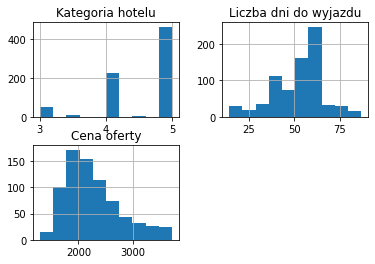

In [112]:
# Rozkład cech:
dane_ML.hist(bins = 10)

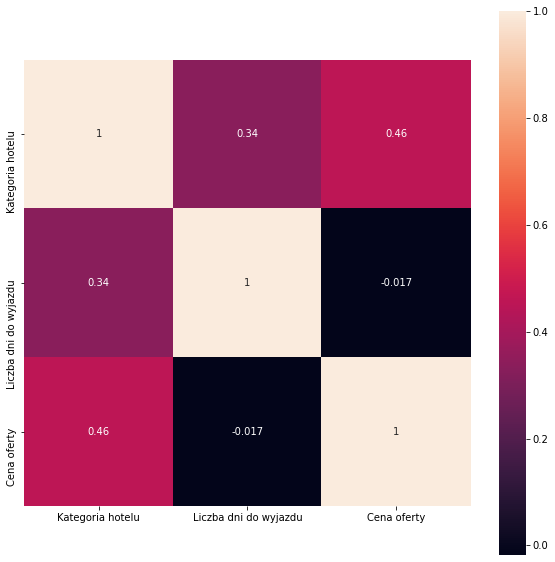

In [113]:
# Sprawdzenie korelacji między zmiennymi:
korelacja = dane_ML.corr()
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(korelacja, square = True, annot = True)

Jak widać, między zmiennymi nie ma dużej korelacji. Trudno więc o usuwanie jakiejkolwiek ze względu na to kryterium.

4. Kodowanie zmiennych kategorycznych

Do zakodowania mamy dwie zmienne: 'Region' i 'Rodzaj wyżywienia'. Zakodujemy je za pomocą funkcji get_dummies():

In [115]:
dane_ML = pd.get_dummies(dane_ML, columns = ['Region'], prefix_sep = ': ')
dane_ML.head(10)

,Kategoria hotelu,Liczba dni do wyjazdu,Cena oferty,Region: Riwiera Egejska,Region: Riwiera Turecka
0,5.0,70,1719.0,0,1
1,5.0,60,2110.0,0,1
2,5.0,46,2183.0,1,0
3,5.0,73,1832.0,0,1
4,5.0,42,1782.0,0,1
5,4.0,56,1678.0,0,1
6,4.0,59,1678.0,0,1
7,5.0,45,2618.0,0,1
8,5.0,70,1605.0,0,1
9,5.0,73,1946.0,0,1


# 3. Tworzenie i zastosowanie modelu uczenia maszynowego

1. Podział danych na zbiory uczący i testowy:

In [116]:
# Tworzenie zbiorów: zmienne objaśniające i zmienna objaśniana:
X = dane_ML.drop(columns = 'Cena oferty')
y = dane_ML['Cena oferty']

# Podział danych na zbiory:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size = 0.2, random_state = 2000)

# Rozmiary utworzonych zbiorów:
print('X_uczący: ', X_train.shape, ', X_testowy: ', X_test.shape, '\n', 'y_uczący: ', y_train.shape, ', y_testowy', y_test.shape)

X_uczący:  (607, 4) , X_testowy:  (152, 4) 
 y_uczący:  (607,) , y_testowy (152,)


2. Standaryzacja zmiennych objaśniających:

In [117]:
# Standaryzujemy zmienne objaśniające zbiorów testowego i uczącego:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

print(X_train_std.shape)
X_train_std

(607, 4)


array([[-2.50788851, -0.76841547, -0.5041153 ,  0.5041153 ],
       [-0.88584448, -0.92106748,  1.9836732 , -1.9836732 ],
       [-0.88584448,  0.45280054,  1.9836732 , -1.9836732 ],
       ...,
       [ 0.73619956,  0.45280054, -0.5041153 ,  0.5041153 ],
       [ 0.73619956,  0.30014854, -0.5041153 ,  0.5041153 ],
       [ 0.73619956,  1.90299457, -0.5041153 ,  0.5041153 ]])

3. Stworzenie i uczenie modelu:

Wykorzystamy i sprawdzimy pięć modeli regresji (albowiem, temat predykcji ceny na podstawie parametrów wybitnie wymaga zastosowania modeli regresji):

* Standardowy model regresji liniowej - LinearRegression(),
* Model Ridge(),
* Model Lasso(),
* Model ElasticNet(),
* Model RandomForestClassifier().

Zastosujemy każdy z modeli (na początku, wszystkie, na domyślnych parametrach), dokonamy predykcji i obliczymy wartości MSE i RMSE.

In [118]:
# Tworzenie modeli:
models = {'Standard Linear': linear_model.LinearRegression(),
          'Ridge': linear_model.Ridge(),
          'Lasso': linear_model.Lasso(),
          'Elastic Net': linear_model.ElasticNet(),
          'Losowy las': RandomForestRegressor()}

# Zastosowanie modeli do predykcji i obliczenia błędu średniokwadratowego:
for key in models:
  reg = models[key]                                       # Wybranie modelu do predykcji
  reg.fit(X_train_std, y_train)                           # Uczenie wybranego modelu

  y_pred = reg.predict(X_test_std)                        # Predykcja na podstawie modelu

  print('Used model: ', models[key])
  MSE = metrics.mean_squared_error(y_test, y_pred)        # Obliczenie błędu średniokwadratowego
  RMSE = np.sqrt(MSE)                                     # Obliczenie pierwiastka błędu średniokwadratowego
  print('MSE = ', round(MSE, 4))
  print('RMSE = ', round(RMSE, 4))
  print('----------------------------------------------------------------------')


Used model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
MSE =  205525.8001
RMSE =  453.3495
----------------------------------------------------------------------
Used model:  Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
MSE =  204874.212
RMSE =  452.6303
----------------------------------------------------------------------
Used model:  Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
MSE =  204903.5742
RMSE =  452.6628
----------------------------------------------------------------------
Used model:  ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start

Jak widzimy, najmniej pomylił się model Lasso. Na drugim miejscu jest Ridge. Model ElasticNet również jest ok. ale za to model standardowej regresji liniowej po prostu ssie. Teraz dokonamy walidacji modeli:

4. Wstępna walidacja modeli:

In [119]:
# Znów wykorzystamy te same modele:
models = {'Standard Linear': linear_model.LinearRegression(),
          'Ridge': linear_model.Ridge(),
          'Lasso': linear_model.Lasso(),
          'Elastic Net': linear_model.ElasticNet(),
          'Losowy las': RandomForestRegressor()}

# Tworzenie procesu standaryzacji i doboru modelu przy każdym podziale walidacji krzyżowej, dla każdego z modeli:
for key in models:

  stand = StandardScaler()                                            # Metoda standaryzacji danych
  model = models[key]                                                 # Wybór metody modelowania
  proces = pipeline.make_pipeline(stand, model)                       # Tworzenie procesu standaryzacji i wykorzystania modelu regresji
  walidacja = model_selection.KFold(n_splits = 10,                    # Zdefiniowanie metody walidacji modelu
                                    shuffle = True,
                                    random_state = 2000)
  
  walidacja_neg_MSE = model_selection.cross_val_score(proces,         # Krzyżowa walidacja modelu ze sprawdzeniem negatywnego MSE
                                                      X_train,
                                                      y_train,
                                                      cv = walidacja,
                                                      scoring = 'neg_mean_squared_error',
                                                      n_jobs = -1)
  
  walidacja_RMSE = np.sqrt(- walidacja_neg_MSE)                       # Obliczenie pierwiastka błędu średniokwadratowego

  # Prezentacja wyników:
  print('model: ', model)
  print(f'Średnia wartość RMSE dla tego modelu = {walidacja_RMSE.mean()}')
  print(f'Mediana RMSE dla tego modelu = {np.median(walidacja_RMSE)}')
  print(f'Odchylenie standardowe RMSE dla tego modelu = {walidacja_RMSE.std()}')
  print('-------------------------------------------------------------------------------------------')

model:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Średnia wartość RMSE dla tego modelu = 443.41114856292205
Mediana RMSE dla tego modelu = 450.93578763725054
Odchylenie standardowe RMSE dla tego modelu = 31.798635084318583
-------------------------------------------------------------------------------------------
model:  Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Średnia wartość RMSE dla tego modelu = 443.4853639438408
Mediana RMSE dla tego modelu = 450.9316411699501
Odchylenie standardowe RMSE dla tego modelu = 31.876590441988373
-------------------------------------------------------------------------------------------
model:  Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
Średnia wartość RMSE dla tego modelu =

Po dogłębnej analizie okazało się, że zwyciężył model RandomForestRegressor(), który uzyskał najmniejszą średnią wartość RMSE (595,03 zł/osoba). Ale wciąż ta wartość pomyłek nie mieści się w zakładanym zakresie tolerancji (zakładaliśmy 500 zł/os.) W następnym kroku spróbujemy zoptymalizować parametry tego modelu tak, aby był on jeszcze mniej omylny.

5. Optymalizacja wybranego modelu regresji:

W celu dobrania optymalnych wartości parametrów wykorzystamy funkcję GridSearchCV():

In [120]:
# Zdefiniowanie siatki parametrów do ustawiania:
siatka_parametrów = [{'n_estimators': [20, 50, 100],                # Liczba drzew
                      'min_samples_split': [2, 5, 20, 50],          # Minimalna liczba próbek wymagana do podzielenia węzła
                      'max_depth': [3, 10, None]},                  # Maksymalna głębokośc drzewa
                     {'bootstrap': [False, True],                   # Metoda doboru próbek do uczenia każdego drzewa (False -> używamy całego zestawu danych)
                      'n_estimators': [10, 100, 300, 500, 1000],    # Liczba drzew
                      'min_samples_leaf': [1, 3, 5],                # Minimalna liczba próbek wymagana w każdym liściu drzewa
                      'max_features': ['auto', 'sqrt']}]            # Liczba cech/funkcji, które należy wziąć pod uwagę, szukając najlepszego podziału (auto -> n_features, sqrt -> sqrt(n_features))

# Zdefiniowanie metody walidacji modelu:
walidacja = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 2000)

# Konfiguracja procesu testowania siatki parametrów
# Funkcja dobierze optymalne wartości parametrów z siatki tak aby zminimalizować wartość MSE:
konfiguracja = pipeline.make_pipeline(StandardScaler(),
                                      model_selection.GridSearchCV(model,
                                                                   siatka_parametrów,
                                                                   cv = walidacja,
                                                                   verbose = 5,
                                                                   scoring = 'neg_mean_squared_error',
                                                                   n_jobs = -1))

# Uczenie modelu ze skonfugurowanymi w wyniku użycia GridSearchCV() parametrami:
konfiguracja.fit(X_train, y_train)

konfig_siatka = konfiguracja.named_steps['gridsearchcv']

# Wyświetl najlepsze parametry modelu:
print('Parametry optymalne dla modelu:')
konfig_siatka.best_params_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 252 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:   59.3s
[Parallel(n_jobs=-1)]: Done 582 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 942 tasks      | elapsed:  4.3min


Parametry optymalne dla modelu:


[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:  4.6min finished


{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'n_estimators': 100}

Jeśli już wybraliśmy optymalne parametry, to spróbujmy coś przewidzieć na podstawie tego modelu...

In [121]:
# Model doskonały :-)
best_model = konfig_siatka.best_estimator_

# Predykcja na tym modelu:
y_pred = best_model.predict(X_test_std)

# Wyliczenie metryk:
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

print(f'Wartość MSE dla modelu idealnego = {MSE: 4}')
print(f'Wartość RMSE dla modelu idealnego = {RMSE: 4}')

Wartość MSE dla modelu idealnego =  207029.89912035747
Wartość RMSE dla modelu idealnego =  455.0053836168947


In [122]:
# Predykcja na całym zbiorze:

predykcja_cały_zbiór = best_model.predict(stand.fit_transform(X))

dane_ML['Cena przewidziana'] = predykcja_cały_zbiór

# Błąd względny predykcji:
dane_ML['Błąd bezwzględny predykcji'] = abs(dane_ML['Cena przewidziana'] - dane_ML['Cena oferty'])
dane_ML['Błąd predykcji'] = abs(dane_ML['Cena przewidziana'] - dane_ML['Cena oferty']) / dane_ML['Cena oferty']

In [123]:
# Wykres cen przewidzianych przez model:
px.scatter(dane_ML,
           x = 'Liczba dni do wyjazdu',
           y = 'Cena przewidziana',
           color = 'Błąd predykcji',
           title = 'Zależność ceny wyznaczonej przez model od liczby dni pozostałych do wyjazdu ze wskazaniem błędu predykcji')

In [124]:
# Wykres cen rzeczywistych:
px.scatter(dane_ML,
           x = 'Liczba dni do wyjazdu',
           y = 'Cena oferty',
           color = 'Błąd predykcji',
           title = 'Zależność ceny rzeczywistej wycieczki od liczby dni pozostałych do wyjazdu ze wskazaniem błędu predykcji')

In [129]:
# W ilu przypadkach model rzeczywiście pomylił się o nie więcej niż 500 zł?
x = dane_ML[dane_ML['Błąd bezwzględny predykcji'] <= 500]
print(f'Procent przypadków, w których model osiągnął zakładany pułap błędu = {100 * round(x.shape[0] / dane_ML.shape[0], 4)} %.')

Procent przypadków, w których model osiągnął zakładany pułap błędu = 79.31 %.
